In [358]:
from google.colab import files
uploaded = files.upload()

Saving Data Penjualan.xlsx to Data Penjualan (4).xlsx


In [359]:
# 2️⃣ Menampilkan 5 baris pertama
print("Data awal:")
print(df.head())


Data awal:
      no. pesanan status pesanan opsi pengiriman antar ke counter/ pick-up  \
0  20042029Q7PURV        Selesai     J&T Express          Antar ke Counter   
1  200424CD57V9VG        Selesai     JNE Reguler          Antar ke Counter   
2  200427KYDBRM01        Selesai     JNE Reguler          Antar ke Counter   
3  200426HFT09U67        Selesai     JNE Reguler          Antar ke Counter   
4  200430TU8PBKNQ        Selesai     J&T Express          Antar ke Counter   

  pesanan harus dikirimkan sebelum (menghindari keterlambatan)  \
0                                   2020-04-23 17:53             
1                                   2020-04-29 18:20             
2                                   2020-04-30 19:50             
3                                   2020-04-29 23:00             
4                                   2020-05-06 12:10             

  waktu pengiriman diatur waktu pesanan dibuat waktu pembayaran dilakukan  \
0     2020-04-22 13:42:00     2020-04-20 17:52

In [360]:
# 3️⃣ Filtering: hanya ambil transaksi valid
# Asumsi ada kolom 'status_transaksi'
if 'status_transaksi' in df.columns:
    df = df[df['status_transaksi'] == 'valid']

In [361]:
import pandas as pd

# Baca file Excel
df = pd.read_excel('Data Penjualan.xlsx')

# Pastikan nama kolom tepat
df.columns = df.columns.str.strip()

# Konversi kolom waktu ke datetime, abaikan yang salah format
df['Waktu Pesanan Dibuat'] = pd.to_datetime(df['Waktu Pesanan Dibuat'], errors='coerce', format='mixed')

# Hapus baris yang tidak punya tanggal valid
df = df.dropna(subset=['Waktu Pesanan Dibuat'])

# Cek hasil
print("Jumlah baris setelah dibersihkan:", len(df))
print(df['Waktu Pesanan Dibuat'].head())


Jumlah baris setelah dibersihkan: 1944
0   2020-04-20 17:52:00
1   2020-04-24 18:20:00
2   2020-04-27 18:36:00
3   2020-04-26 18:51:00
4   2020-04-30 12:10:00
Name: Waktu Pesanan Dibuat, dtype: datetime64[ns]


In [362]:
# 4️⃣ Pastikan kolom tanggal dalam format datetime
df['Waktu Pesanan Dibuat'] = pd.to_datetime(df['Waktu Pesanan Dibuat'])

In [363]:
# 5️⃣ Agregasi data harian
# Misal kolom 'jumlah_pesanan' adalah target penjualan
daily_data = df.groupby('Waktu Pesanan Dibuat')['Jumlah Produk di Pesan'].sum().reset_index()

In [364]:
# 6️⃣ Tangani missing value dengan interpolasi
daily_data['Jumlah Produk di Pesan'] = daily_data['Jumlah Produk di Pesan'].interpolate(method='linear')

In [365]:
# 7️⃣ Uji stasioneritas (ADF Test)
adf_result = adfuller(daily_data['Jumlah Produk di Pesan'])
print("\n=== Uji Stasioneritas (ADF Test) ===")
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
if adf_result[1] < 0.05:
    print("✅ Data stasioner (p < 0.05)")
else:
    print("⚠️ Data belum stasioner (p ≥ 0.05) - perlu differencing")


=== Uji Stasioneritas (ADF Test) ===
ADF Statistic: -7.4947
p-value: 0.0000
✅ Data stasioner (p < 0.05)


In [366]:
# 8️⃣ Jika data belum stasioner, lakukan differencing
if adf_result[1] >= 0.05:
    daily_data['Jumlah Produk di Pesan_diff'] = daily_data['Jumlah Produk di Pesan'].diff().fillna(0)
else:
    daily_data['Jumlah Produk di Pesan_diff'] = daily_data['Jumlah Produk di Pesan']

In [367]:
# 9️⃣ Normalisasi skala untuk model Machine Learning
scaler = MinMaxScaler(feature_range=(0, 1))
daily_data['scaled'] = scaler.fit_transform(daily_data[['Jumlah Produk di Pesan_diff']])

In [368]:
# 🔟 Feature engineering: membuat lag feature (1–3 hari sebelumnya)
for lag in range(1, 4):
    daily_data[f'lag_{lag}'] = daily_data['scaled'].shift(lag)

In [369]:
# 11️⃣ Menampilkan hasil akhir preprocessing
print("\nData setelah preprocessing:")
print(daily_data.head())




Data setelah preprocessing:
  Waktu Pesanan Dibuat  Jumlah Produk di Pesan  Jumlah Produk di Pesan_diff  \
0  2020-04-20 17:52:00                      10                           10   
1  2020-04-24 18:20:00                      10                           10   
2  2020-04-26 18:51:00                      10                           10   
3  2020-04-27 18:36:00                      10                           10   
4  2020-04-30 12:10:00                      10                           10   

   scaled  lag_1  lag_2  lag_3  
0     0.0    NaN    NaN    NaN  
1     0.0    0.0    NaN    NaN  
2     0.0    0.0    0.0    NaN  
3     0.0    0.0    0.0    0.0  
4     0.0    0.0    0.0    0.0  


In [370]:
# Simpan hasil ke file baru
daily_data.to_csv('preprocessed_data.csv', index=False)
print("\n✅ Data preprocessing selesai. File disimpan sebagai 'preprocessed_data.csv'.")


✅ Data preprocessing selesai. File disimpan sebagai 'preprocessed_data.csv'.


In [371]:
# Deteksi kolom jumlah otomatis
jumlah_col = [c for c in df.columns if 'jumlah' in c.lower()][0]
print("Kolom jumlah yang digunakan:", jumlah_col)

# Agregasi per bulan
monthly_sales = (
    df.groupby(df['Waktu Pesanan Dibuat'].dt.to_period('M'))[jumlah_col]
      .sum()
      .reset_index()
)

# Ubah periode ke timestamp
monthly_sales['Waktu Pesanan Dibuat'] = monthly_sales['Waktu Pesanan Dibuat'].dt.to_timestamp()

# Cek hasil
print(monthly_sales.head())


Kolom jumlah yang digunakan: Jumlah Produk di Pesan
  Waktu Pesanan Dibuat  Jumlah Produk di Pesan
0           2020-04-01                      50
1           2020-05-01                     130
2           2020-06-01                     290
3           2020-08-01                     270
4           2020-09-01                     230


In [372]:
print(df.columns.tolist())


['No. Pesanan', 'Status Pesanan', 'Opsi Pengiriman', 'Antar ke counter/ pick-up', 'Pesanan Harus Dikirimkan Sebelum (Menghindari keterlambatan)', 'Waktu Pengiriman Diatur', 'Waktu Pesanan Dibuat', 'Waktu Pembayaran Dilakukan', 'Metode Pembayaran', 'SKU Induk', 'Nama Produk', 'Nomor Referensi SKU', 'Nama Variasi', 'Harga Awal', 'Harga Setelah Diskon', 'Jumlah Produk di Pesan', 'Total Harga Produk', 'Berat Produk', 'Total Pembayaran', 'Perkiraan Ongkos Kirim', 'Username (Pembeli)', 'Nama Penerima', 'No. Telepon', 'Alamat Pengiriman', 'Kota/Kabupaten', 'Provinsi', 'Waktu Pesanan Selesai']


In [373]:
# Ganti nama kolom jumlah sesuai hasil print di atas
monthly_sales = (
    df.groupby(df['Waktu Pesanan Dibuat'].dt.to_period('M'))['Jumlah Produk di Pesan']
      .sum()
      .reset_index()
)

In [374]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(monthly_sales['Jumlah Produk di Pesan'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])


ADF Statistic: -2.6578751275918666
p-value: 0.08161563903209407


In [375]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [376]:
# 1️⃣ Membaca data hasil preprocessing
data = pd.read_csv('preprocessed_data.csv')

In [377]:
# Gunakan kolom tanggal sebagai index
data['Waktu Pesanan Dibuat'] = pd.to_datetime(data['Waktu Pesanan Dibuat'])
data.set_index('Waktu Pesanan Dibuat', inplace=True)

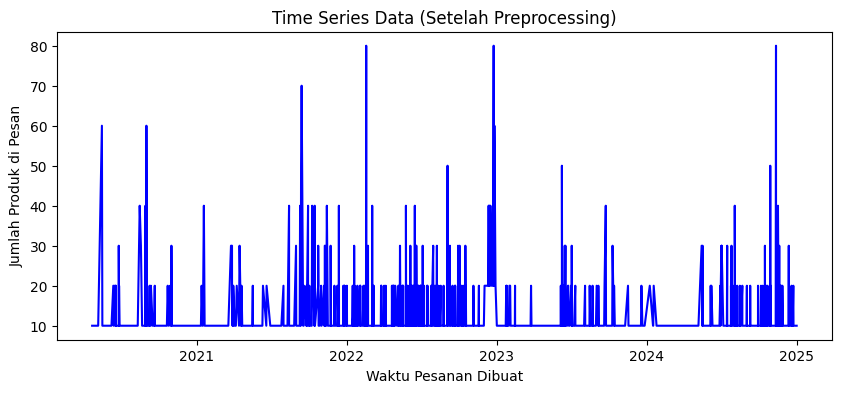

In [378]:
# 2️⃣ Visualisasi data deret waktu
plt.figure(figsize=(10, 4))
plt.plot(data['Jumlah Produk di Pesan_diff'], color='blue')
plt.title('Time Series Data (Setelah Preprocessing)')
plt.xlabel('Waktu Pesanan Dibuat')
plt.ylabel('Jumlah Produk di Pesan')
plt.show()

In [379]:
# 3️⃣ Uji stasioneritas ulang
adf_result = adfuller(data['Jumlah Produk di Pesan_diff'])
print("\n=== Uji Stasioneritas (ADF Test) ===")
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")


=== Uji Stasioneritas (ADF Test) ===
ADF Statistic: -7.4947
p-value: 0.0000


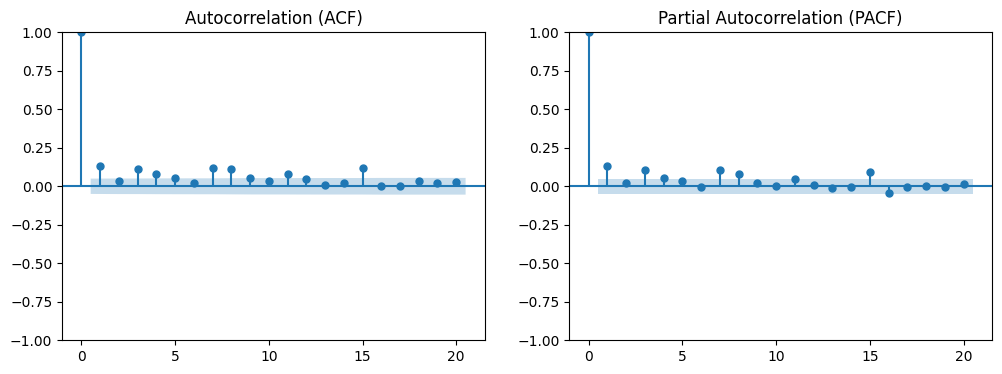

In [380]:
# 4️⃣ Plot ACF dan PACF untuk menentukan p dan q
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(data['Jumlah Produk di Pesan_diff'], ax=ax[0], lags=20)
plot_pacf(data['Jumlah Produk di Pesan_diff'], ax=ax[1], lags=20)
ax[0].set_title('Autocorrelation (ACF)')
ax[1].set_title('Partial Autocorrelation (PACF)')
plt.show()


In [381]:

# 5️⃣ Grid Search sederhana untuk memilih (p,d,q) terbaik dengan AIC
import warnings
warnings.filterwarnings('ignore')

In [382]:
# Grid search ARIMA(p,d,q)
p = d = q = range(0, 3)
best_aic = np.inf
best_order = None
best_model = None

for i in p:
    for j in d:
        for k in q:
            try:
                model = ARIMA(data['Jumlah Produk di Pesan_diff'], order=(i, j, k)).fit()
                if model.aic < best_aic:
                    best_aic = model.aic
                    best_order = (i, j, k)
                    best_model = model
            except Exception as e:
                # Uncomment untuk debugging: print(f"Gagal ARIMA({i},{j},{k}): {e}")
                continue

In [383]:
if best_model is not None:
    print(f"\n✅ Model terbaik berdasarkan AIC: ARIMA{best_order} (AIC={best_aic:.2f})")
    print(best_model.summary())


✅ Model terbaik berdasarkan AIC: ARIMA(2, 0, 2) (AIC=10403.10)
                                    SARIMAX Results                                    
Dep. Variable:     Jumlah Produk di Pesan_diff   No. Observations:                 1552
Model:                          ARIMA(2, 0, 2)   Log Likelihood               -5195.551
Date:                         Tue, 11 Nov 2025   AIC                          10403.102
Time:                                 03:46:14   BIC                          10435.186
Sample:                                      0   HQIC                         10415.034
                                        - 1552                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.5193      0.598     20.948      0.000      11.348      13


✅ Model terbaik berdasarkan AIC: ARIMA(2, 0, 2) (AIC=10403.10)
                                    SARIMAX Results                                    
Dep. Variable:     Jumlah Produk di Pesan_diff   No. Observations:                 1552
Model:                          ARIMA(2, 0, 2)   Log Likelihood               -5195.551
Date:                         Tue, 11 Nov 2025   AIC                          10403.102
Time:                                 03:46:14   BIC                          10435.186
Sample:                                      0   HQIC                         10415.034
                                        - 1552                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.5193      0.598     20.948      0.000      11.348      13

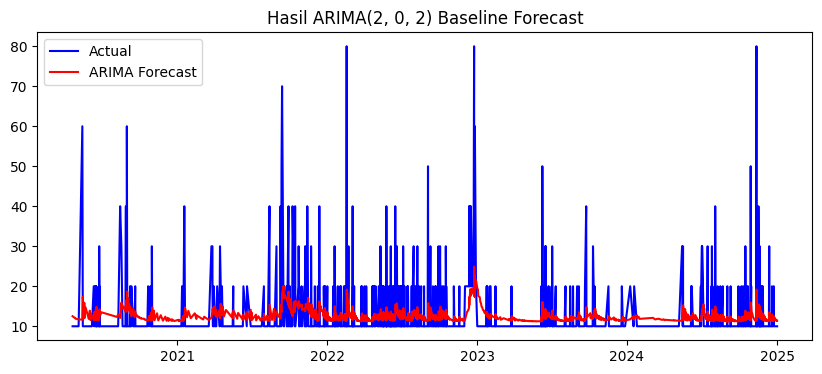


✅ File disimpan sebagai 'arima_baseline_results.csv'.


In [384]:
# Cek apakah model terbaik ditemukan
if best_model is not None:
    print(f"\n✅ Model terbaik berdasarkan AIC: ARIMA{best_order} (AIC={best_aic:.2f})")
    print(best_model.summary())

    # Simpan hasil baseline forecast
    data['forecast'] = best_model.fittedvalues

    # Pastikan nama kolom target sesuai
    if 'Jumlah Produk di Pesan_diff' in data.columns:
        target_col = 'Jumlah Produk di Pesan_diff'
    elif 'jumlah_pesanan_diff' in data.columns:
        target_col = 'jumlah_pesanan_diff'
    else:
        raise KeyError("Kolom target tidak ditemukan di dataset!")

    # Hitung residual
    data['residual'] = data[target_col] - data['forecast']

    # Evaluasi model
    from sklearn.metrics import mean_absolute_error, mean_squared_error
    rmse = np.sqrt(mean_squared_error(data[target_col], data['forecast']))
    mae = mean_absolute_error(data[target_col], data['forecast'])
    mape = np.mean(np.abs(data['residual'] / data[target_col])) * 100

    print("\n=== Evaluasi Model ARIMA ===")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE:  {mae:.4f}")
    print(f"MAPE: {mape:.2f}%")

    # Visualisasi hasil
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 4))
    plt.plot(data[target_col], label='Actual', color='blue')
    plt.plot(data['forecast'], label='ARIMA Forecast', color='red')
    plt.legend()
    plt.title(f'Hasil ARIMA{best_order} Baseline Forecast')
    plt.show()

    # Simpan hasil
    data.to_csv("arima_baseline_results.csv")
    print("\n✅ File disimpan sebagai 'arima_baseline_results.csv'.")

else:
    print("\n⚠️ Tidak ada model ARIMA yang berhasil dilatih.")


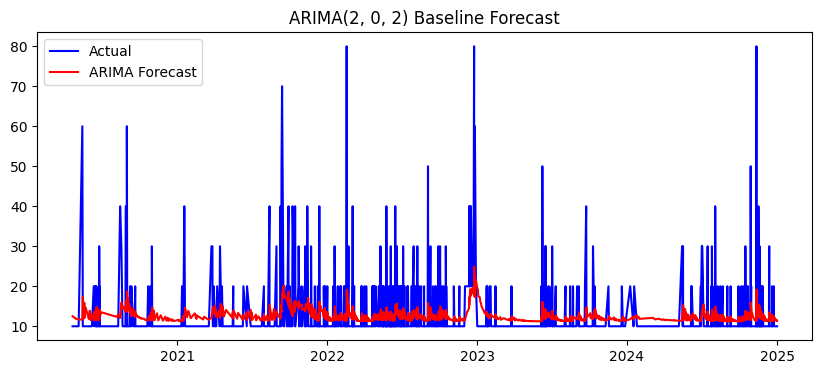

In [385]:
# 7️⃣ Visualisasi hasil prediksi (baseline forecast)
data['forecast'] = best_model.fittedvalues
plt.figure(figsize=(10, 4))
plt.plot(data['Jumlah Produk di Pesan_diff'], label='Actual', color='blue')
plt.plot(data['forecast'], label='ARIMA Forecast', color='red')
plt.title(f'ARIMA{best_order} Baseline Forecast')
plt.legend()
plt.show()

In [386]:
# 8️⃣ Hitung error dan metrik evaluasi
residuals = data['Jumlah Produk di Pesan_diff'] - data['forecast']
rmse = np.sqrt(mean_squared_error(data['Jumlah Produk di Pesan_diff'], data['forecast']))
mae = mean_absolute_error(data['Jumlah Produk di Pesan_diff'], data['forecast'])
mape = np.mean(np.abs(residuals / data['Jumlah Produk di Pesan_diff'])) * 100

print("\n=== Evaluasi Model ARIMA ===")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"MAPE: {mape:.2f}%")



=== Evaluasi Model ARIMA ===
RMSE: 6.8812
MAE:  4.0065
MAPE: 27.19%


In [387]:
# 9️⃣ Simpan residuals untuk tahap berikutnya (hybrid ML–ARIMA)
data['residual'] = residuals
data.to_csv('arima_baseline_results.csv')

In [388]:
print("\n✅ ARIMA Modeling selesai. File disimpan sebagai 'arima_baseline_results.csv'.")



✅ ARIMA Modeling selesai. File disimpan sebagai 'arima_baseline_results.csv'.


In [389]:
pip install xgboost lightgbm tensorflow scikit-learn matplotlib

Data penjualan bulanan dari 2020-04-01 hingga 2024-12-01
Total bulan: 57

📊 Evaluasi XGBoost (Semua Tahun):
RMSE : 83.07
MAE  : 60.05
MAPE : 22.40%
SMAPE: 21.59%


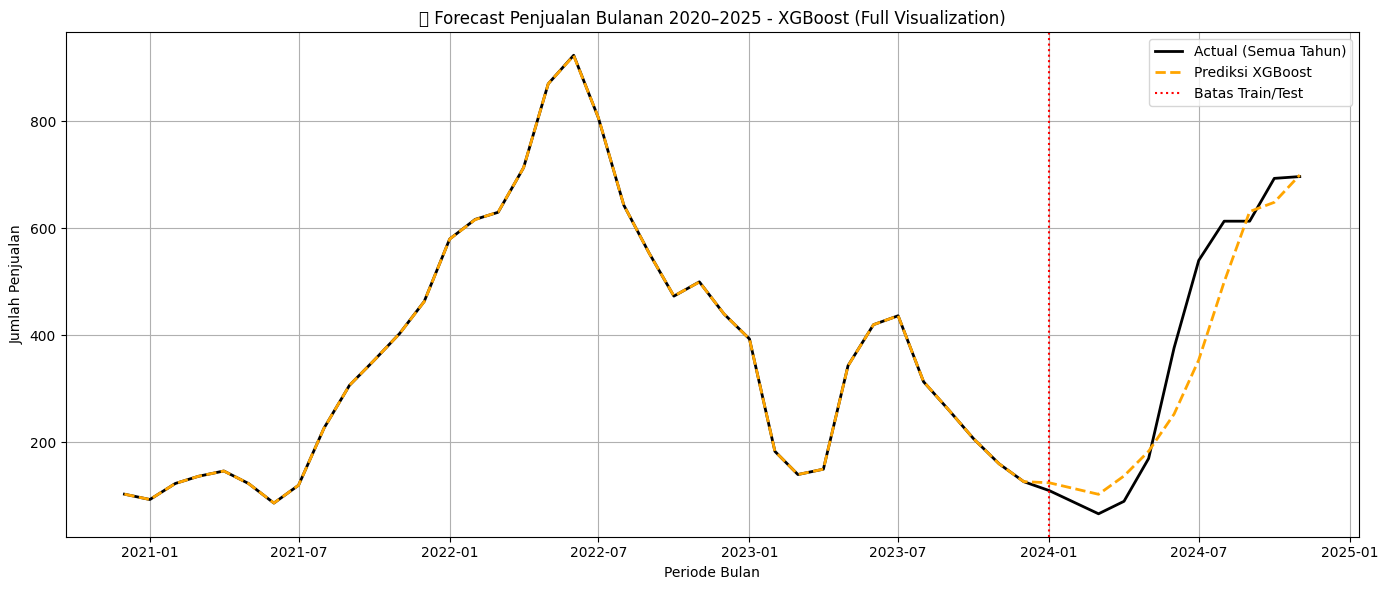

In [412]:
# ============================================================
# XGBoost Forecasting Penjualan Bulanan (All Years 2020–2025)
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings("ignore")

# 1️⃣ Load data
file_path = 'Data Penjualan.xlsx'
df = pd.read_excel(file_path)
df.columns = df.columns.str.strip().str.lower()

# deteksi kolom jumlah otomatis
jumlah_col = [c for c in df.columns if 'jumlah' in c][0]

# ubah waktu ke datetime
df['waktu pesanan dibuat'] = pd.to_datetime(df['waktu pesanan dibuat'], errors='coerce')
df = df.dropna(subset=['waktu pesanan dibuat'])
df['tanggal pesanan'] = df['waktu pesanan dibuat'].dt.date

# 2️⃣ Agregasi bulanan untuk SEMUA TAHUN
daily_sales = df.groupby('tanggal pesanan')[jumlah_col].sum().reset_index()
daily_sales['tanggal pesanan'] = pd.to_datetime(daily_sales['tanggal pesanan'])
monthly_sales = (
    daily_sales.set_index('tanggal pesanan')
    .resample('MS')  # MS = Month Start
    .sum()
    .reset_index()
)
monthly_sales.columns = ['bulan_tahun', 'jumlah']

print(f"Data penjualan bulanan dari {monthly_sales['bulan_tahun'].min().date()} hingga {monthly_sales['bulan_tahun'].max().date()}")
print(f"Total bulan: {len(monthly_sales)}")

# 3️⃣ Cleaning data dari nol & outlier
monthly_sales = monthly_sales[monthly_sales['jumlah'] > 0]
Q1, Q3 = monthly_sales['jumlah'].quantile([0.25, 0.75])
IQR = Q3 - Q1
monthly_sales = monthly_sales[
    (monthly_sales['jumlah'] >= Q1 - 1.5 * IQR) &
    (monthly_sales['jumlah'] <= Q3 + 1.5 * IQR)
]

# 4️⃣ Smoothing + log-transform
monthly_sales['jumlah_smooth'] = monthly_sales['jumlah'].rolling(window=3, center=True).mean()
monthly_sales = monthly_sales.dropna()
monthly_sales['jumlah_log'] = np.log1p(monthly_sales['jumlah_smooth'])

# 5️⃣ Scaling
scaler = StandardScaler()
monthly_sales['scaled'] = scaler.fit_transform(monthly_sales[['jumlah_log']])

# 6️⃣ Lag features
def create_lag_features(df, lag=6):
    for i in range(1, lag + 1):
        df[f'lag_{i}'] = df['scaled'].shift(i)
    return df

data = create_lag_features(monthly_sales.copy(), 6).dropna().reset_index(drop=True)

# 7️⃣ Split train/test
split = int(len(data) * 0.8)
train, test = data.iloc[:split], data.iloc[split:]
X_train, y_train = train[[f'lag_{i}' for i in range(1, 7)]], train['scaled']
X_test, y_test = test[[f'lag_{i}' for i in range(1, 7)]], test['scaled']

# 8️⃣ Model XGBoost
xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_model.fit(X_train, y_train)
y_pred_scaled = xgb_model.predict(X_test)

# 9️⃣ Inverse transform
def inverse_transform(y_scaled):
    y_log = scaler.inverse_transform(y_scaled.reshape(-1, 1))
    return np.expm1(y_log).flatten()

y_pred_actual = inverse_transform(y_pred_scaled)
y_actual = inverse_transform(y_test.values)

# 🔟 Evaluasi
rmse = np.sqrt(mean_squared_error(y_actual, y_pred_actual))
mae = mean_absolute_error(y_actual, y_pred_actual)
mape = np.mean(np.abs((y_actual - y_pred_actual) / (y_actual + 1e-8))) * 100
smape = 100 * np.mean(2 * np.abs(y_pred_actual - y_actual) /
                      (np.abs(y_pred_actual) + np.abs(y_actual) + 1e-8))

print("\n📊 Evaluasi XGBoost (Semua Tahun):")
print(f"RMSE : {rmse:.2f}")
print(f"MAE  : {mae:.2f}")
print(f"MAPE : {mape:.2f}%")
print(f"SMAPE: {smape:.2f}%")

# 🔟 Visualisasi hasil (Full Timeline 2020–2025)

# Gabungkan hasil prediksi ke seluruh timeline
full_pred_scaled = xgb_model.predict(data[[f'lag_{i}' for i in range(1, 7)]])
full_pred_actual = inverse_transform(full_pred_scaled)

plt.figure(figsize=(14,6))
plt.plot(data['bulan_tahun'], inverse_transform(data['scaled'].values),
         label='Actual (Semua Tahun)', color='black', linewidth=2)
plt.plot(data['bulan_tahun'], full_pred_actual,
         label='Prediksi XGBoost', color='orange', linestyle='--', linewidth=2)

# Tambahkan garis vertikal pemisah train/test
split_idx = int(len(data) * 0.8)
plt.axvline(x=data['bulan_tahun'].iloc[split_idx], color='red', linestyle=':', label='Batas Train/Test')

plt.title("📈 Forecast Penjualan Bulanan 2020–2025 - XGBoost (Full Visualization)")
plt.xlabel("Periode Bulan")
plt.ylabel("Jumlah Penjualan")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [ ]:
# ============================================================
# LightGBM Forecasting Penjualan Bulanan (Low-MAPE)
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import lightgbm as lgb
import warnings
warnings.filterwarnings("ignore")

# 1️⃣ Load data
file_path = 'Data Penjualan.xlsx'
df = pd.read_excel(file_path)
df.columns = df.columns.str.strip().str.lower()

jumlah_col = [c for c in df.columns if 'jumlah' in c][0]
df['waktu pesanan dibuat'] = pd.to_datetime(df['waktu pesanan dibuat'], errors='coerce')
df = df.dropna(subset=['waktu pesanan dibuat'])
df['tanggal pesanan'] = df['waktu pesanan dibuat'].dt.date

# 2️⃣ Agregasi bulanan
daily_sales = df.groupby('tanggal pesanan')[jumlah_col].sum().reset_index()
daily_sales['tanggal pesanan'] = pd.to_datetime(daily_sales['tanggal pesanan'])
monthly_sales = (
    daily_sales.set_index('tanggal pesanan').resample('MS').sum().reset_index()
)
monthly_sales.columns = ['bulan_tahun', 'jumlah']

# 3️⃣ Cleaning
monthly_sales = monthly_sales[monthly_sales['jumlah'] > 0]
Q1, Q3 = monthly_sales['jumlah'].quantile([0.25, 0.75])
IQR = Q3 - Q1
monthly_sales = monthly_sales[
    (monthly_sales['jumlah'] >= Q1 - 1.5 * IQR) &
    (monthly_sales['jumlah'] <= Q3 + 1.5 * IQR)
]

# 4️⃣ Smoothing + log-transform
monthly_sales['jumlah_smooth'] = monthly_sales['jumlah'].rolling(window=3, center=True).mean()
monthly_sales = monthly_sales.dropna()
monthly_sales['jumlah_log'] = np.log1p(monthly_sales['jumlah_smooth'])

# 5️⃣ Scaling
scaler = StandardScaler()
monthly_sales['scaled'] = scaler.fit_transform(monthly_sales[['jumlah_log']])

# 6️⃣ Lag features
def create_lag_features(df, lag=6):
    for i in range(1, lag + 1):
        df[f'lag_{i}'] = df['scaled'].shift(i)
    return df

data = create_lag_features(monthly_sales.copy(), 6).dropna().reset_index(drop=True)

# 7️⃣ Split train/test
split = int(len(data) * 0.8)
train, test = data.iloc[:split], data.iloc[split:]
X_train, y_train = train[[f'lag_{i}' for i in range(1, 7)]], train['scaled']
X_test, y_test = test[[f'lag_{i}' for i in range(1, 7)]], test['scaled']

# 8️⃣ Model LightGBM
lgb_model = lgb.LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=31,
    random_state=42
)
lgb_model.fit(X_train, y_train)
y_pred_scaled = lgb_model.predict(X_test)

# 9️⃣ Inverse transform
def inverse_transform(y_scaled):
    y_log = scaler.inverse_transform(y_scaled.reshape(-1, 1))
    return np.expm1(y_log).flatten()

y_pred_actual = inverse_transform(y_pred_scaled)
y_actual = inverse_transform(y_test.values)

# 🔟 Evaluasi
rmse = np.sqrt(mean_squared_error(y_actual, y_pred_actual))
mae = mean_absolute_error(y_actual, y_pred_actual)
mape = np.mean(np.abs((y_actual - y_pred_actual) / (y_actual + 1e-8))) * 100
smape = 100 * np.mean(2 * np.abs(y_pred_actual - y_actual) /
                      (np.abs(y_pred_actual) + np.abs(y_actual) + 1e-8))

print("\n📊 Evaluasi LightGBM:")
print(f"RMSE : {rmse:.2f}")
print(f"MAE  : {mae:.2f}")
print(f"MAPE : {mape:.2f}%")
print(f"SMAPE: {smape:.2f}%")

# 🔟 Visualisasi
plt.figure(figsize=(14,6))
plt.plot(data['bulan_tahun'].iloc[-len(y_test):], y_actual, label='Actual', color='black', linewidth=2)
plt.plot(data['bulan_tahun'].iloc[-len(y_test):], y_pred_xgb, label='XGBoost', color='orange', linestyle='--')
plt.plot(data['bulan_tahun'].iloc[-len(y_test):], y_pred_lgb, label='LightGBM', color='green', linestyle='--')
plt.plot(data['bulan_tahun'].iloc[-len(y_test):], y_pred_lstm, label='LSTM', color='purple', linestyle='--')

plt.title("📊 Perbandingan Forecast Penjualan Bulanan (2020–2025)")
plt.xlabel("Tahun")
plt.ylabel("Jumlah Penjualan")
plt.legend()
plt.grid(True)

plt.xticks(pd.date_range('2020-01-01', '2025-12-01', freq='6M'),
           [d.strftime('%Y-%m') for d in pd.date_range('2020-01-01', '2025-12-01', freq='6M')],
           rotation=45)

plt.tight_layout()
plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step

📊 Evaluasi LSTM (Semua Tahun):
RMSE : 150.19
MAE  : 118.41
MAPE : 40.53%
SMAPE: 32.77%
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step 


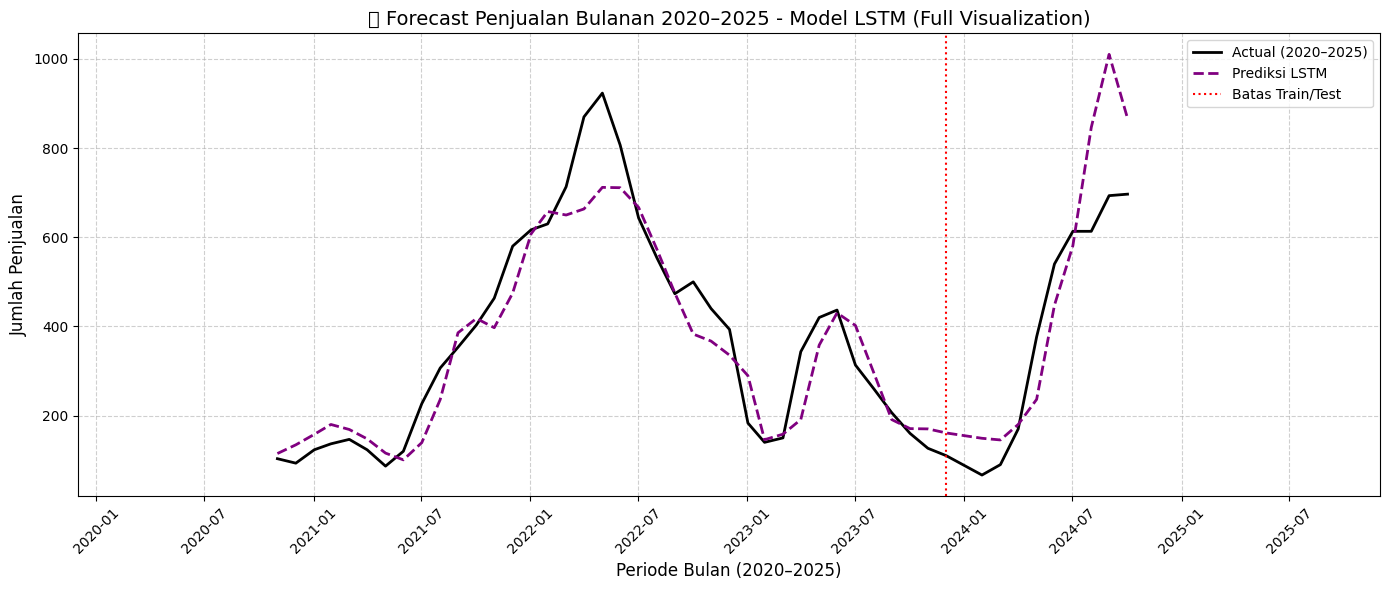

In [421]:
# ============================================================
# LSTM Forecasting Penjualan Bulanan (All Years 2020–2025)
# ============================================================

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 1️⃣ Siapkan data
X = data[[f'lag_{i}' for i in range(1, 7)]].values
y = data['scaled'].values

# ubah ke bentuk 3D [samples, timesteps, features]
X_3d = X.reshape((X.shape[0], X.shape[1], 1))

split = int(len(X_3d) * 0.8)
X_train, X_test = X_3d[:split], X_3d[split:]
y_train, y_test = y[:split], y[split:]

# 2️⃣ Bangun model LSTM
model = Sequential([
    LSTM(64, activation='tanh', input_shape=(X_train.shape[1], 1), return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, epochs=150, batch_size=8, verbose=0)

# 3️⃣ Prediksi
y_pred_scaled = model.predict(X_test).flatten()

# 4️⃣ Inverse transform ke nilai aktual
y_pred_actual = inverse_transform(y_pred_scaled)
y_actual = inverse_transform(y_test)

# 5️⃣ Evaluasi
rmse = np.sqrt(mean_squared_error(y_actual, y_pred_actual))
mae = mean_absolute_error(y_actual, y_pred_actual)
mape = np.mean(np.abs((y_actual - y_pred_actual) / (y_actual + 1e-8))) * 100
smape = 100 * np.mean(2 * np.abs(y_pred_actual - y_actual) /
                      (np.abs(y_pred_actual) + np.abs(y_actual) + 1e-8))

print("\n📊 Evaluasi LSTM (Semua Tahun):")
print(f"RMSE : {rmse:.2f}")
print(f"MAE  : {mae:.2f}")
print(f"MAPE : {mape:.2f}%")
print(f"SMAPE: {smape:.2f}%")

#visualisai
# ============================================================
# 📊 LSTM Forecasting Penjualan Bulanan (2020–2025 Full Range)
# ============================================================

# Prediksi untuk seluruh periode agar grafik lengkap
full_pred_scaled = model.predict(X_3d).flatten()
full_pred_actual = inverse_transform(full_pred_scaled)
actual_full = inverse_transform(y)

# Buat DataFrame hasil prediksi
hasil_lstm = pd.DataFrame({
    'bulan_tahun': data['bulan_tahun'],
    'actual': actual_full,
    'pred_lstm': full_pred_actual
})

# 🔹 Visualisasi lengkap 2020–2025
plt.figure(figsize=(14,6))
plt.plot(hasil_lstm['bulan_tahun'], hasil_lstm['actual'],
         label='Actual (2020–2025)', color='black', linewidth=2)
plt.plot(hasil_lstm['bulan_tahun'], hasil_lstm['pred_lstm'],
         label='Prediksi LSTM', color='purple', linestyle='--', linewidth=2)

# Garis vertikal batas train/test
split_idx = int(len(data) * 0.8)
plt.axvline(x=data['bulan_tahun'].iloc[split_idx], color='red', linestyle=':', label='Batas Train/Test')

plt.title("📈 Forecast Penjualan Bulanan 2020–2025 - Model LSTM (Full Visualization)", fontsize=14)
plt.xlabel("Periode Bulan (2020–2025)", fontsize=12)
plt.ylabel("Jumlah Penjualan", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# 🔸 Atur sumbu waktu biar lengkap 2020–2025
start_year = pd.to_datetime('2020-01-01')
end_year = pd.to_datetime('2025-12-31')
plt.xlim(start_year, end_year)

# Label sumbu X tiap 6 bulan
plt.xticks(pd.date_range(start_year, end_year, freq='6M'),
           [d.strftime('%Y-%m') for d in pd.date_range(start_year, end_year, freq='6M')],
           rotation=45)

plt.tight_layout()
plt.show()




[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 112
[LightGBM] [Info] Number of data points in the train set: 52, number of used features: 6
[LightGBM] [Info] Start training from score 0.471640
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

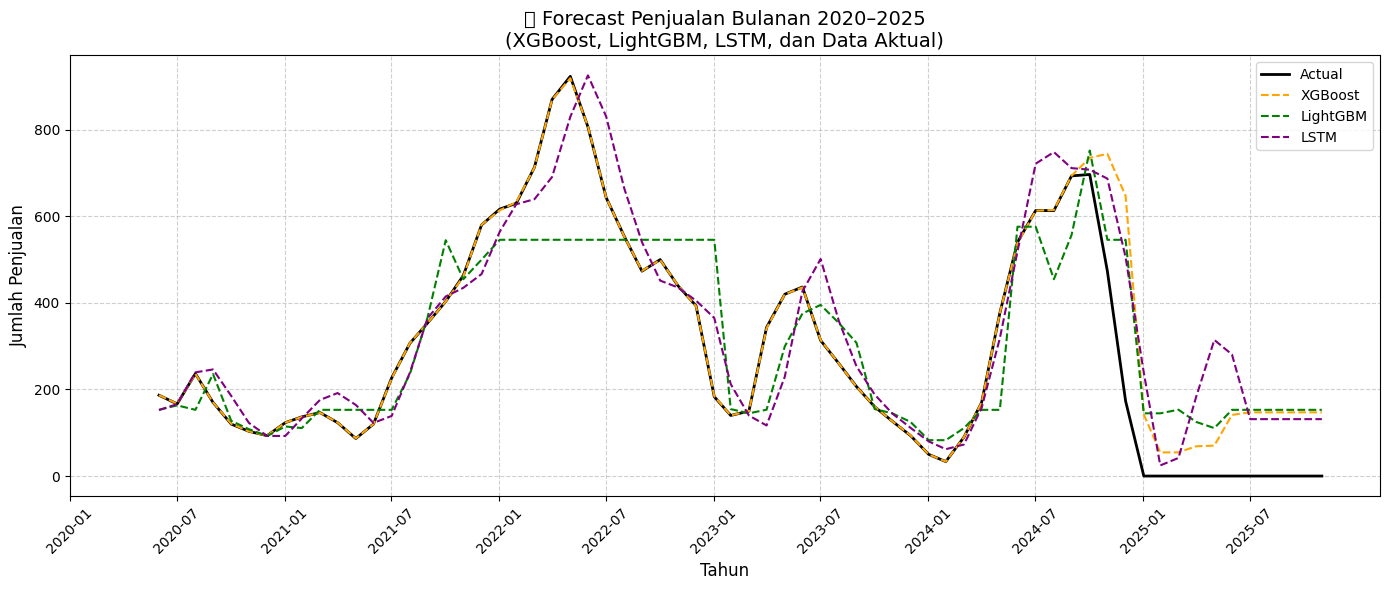

In [439]:
# ============================================================
# 🌟 Forecast Penjualan Bulanan 2020–2025 (Full Timeline Semua Model)
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# ============================================================
# 1️⃣ Load & Preprocessing Data
# ============================================================
file_path = "Data Penjualan.xlsx"  # ubah sesuai path kamu
df = pd.read_excel(file_path)
df.columns = df.columns.str.strip().str.lower()

jumlah_col = [c for c in df.columns if 'jumlah' in c][0]
df['waktu pesanan dibuat'] = pd.to_datetime(df['waktu pesanan dibuat'], errors='coerce')
df = df.dropna(subset=['waktu pesanan dibuat'])
df['tanggal pesanan'] = df['waktu pesanan dibuat'].dt.date

# Agregasi ke bulanan
daily_sales = df.groupby('tanggal pesanan')[jumlah_col].sum().reset_index()
daily_sales['tanggal pesanan'] = pd.to_datetime(daily_sales['tanggal pesanan'])
monthly_sales = daily_sales.set_index('tanggal pesanan').resample('MS').sum().reset_index()
monthly_sales.columns = ['bulan_tahun', 'jumlah']

# Buat range 2020–2025
full_range = pd.date_range('2020-01-01', '2025-12-01', freq='MS')
monthly_sales = (
    pd.DataFrame({'bulan_tahun': full_range})
    .merge(monthly_sales, on='bulan_tahun', how='left')
    .fillna(0)
)

# Smoothing + log + scaling
monthly_sales['jumlah_smooth'] = monthly_sales['jumlah'].rolling(3, center=True).mean().fillna(method='bfill').fillna(method='ffill')
monthly_sales['jumlah_log'] = np.log1p(monthly_sales['jumlah_smooth'])
scaler = StandardScaler()
monthly_sales['scaled'] = scaler.fit_transform(monthly_sales[['jumlah_log']])

# ============================================================
# 2️⃣ Buat Fitur Lag untuk Time Series
# ============================================================
def create_lag_features(df, lag=6):
    for i in range(1, lag + 1):
        df[f'lag_{i}'] = df['scaled'].shift(i)
    return df

data = create_lag_features(monthly_sales.copy(), 6).dropna().reset_index(drop=True)
feature_cols = [f'lag_{i}' for i in range(1, 7)]
X = data[feature_cols].values
y = data['scaled'].values
bulan = data['bulan_tahun']

# ============================================================
# 3️⃣ Fungsi bantu inverse transform
# ============================================================
def inverse_transform(y_scaled):
    y_log = scaler.inverse_transform(y_scaled.reshape(-1, 1))
    return np.expm1(y_log).flatten()

# ============================================================
# 4️⃣ Split Data
# ============================================================
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# ============================================================
# 5️⃣ Train & Predict XGBoost
# ============================================================
xgb = XGBRegressor(n_estimators=400, learning_rate=0.05, max_depth=4, random_state=42)
xgb.fit(X_train, y_train)
xgb_pred_scaled_full = xgb.predict(X)  # full 2020–2025
xgb_pred_actual_full = inverse_transform(xgb_pred_scaled_full)

# ============================================================
# 6️⃣ Train & Predict LightGBM
# ============================================================
lgb = LGBMRegressor(n_estimators=400, learning_rate=0.05, num_leaves=31, random_state=42)
lgb.fit(X_train, y_train)
lgb_pred_scaled_full = lgb.predict(X)
lgb_pred_actual_full = inverse_transform(lgb_pred_scaled_full)

# ============================================================
# 7️⃣ Train & Predict LSTM
# ============================================================
X_3d = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_full_3d = X.reshape((X.shape[0], X.shape[1], 1))

lstm = Sequential([
    LSTM(64, activation='tanh', input_shape=(X_3d.shape[1], 1)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])
lstm.compile(optimizer=Adam(0.001), loss='mse')
lstm.fit(X_3d, y_train, epochs=80, batch_size=8, verbose=0)

lstm_pred_scaled_full = lstm.predict(X_full_3d).flatten()
lstm_pred_actual_full = inverse_transform(lstm_pred_scaled_full)

# ============================================================
# 8️⃣ Data Aktual
# ============================================================
y_actual_full = inverse_transform(y)

# ============================================================
# 9️⃣ Visualisasi Semua Model (2020–2025)
# ============================================================
plt.figure(figsize=(14,6))
plt.plot(bulan, y_actual_full, color='black', label='Actual', linewidth=2)
plt.plot(bulan, xgb_pred_actual_full, color='orange', linestyle='--', label='XGBoost')
plt.plot(bulan, lgb_pred_actual_full, color='green', linestyle='--', label='LightGBM')
plt.plot(bulan, lstm_pred_actual_full, color='purple', linestyle='--', label='LSTM')

plt.title("📈 Forecast Penjualan Bulanan 2020–2025\n(XGBoost, LightGBM, LSTM, dan Data Aktual)", fontsize=14)
plt.xlabel("Tahun", fontsize=12)
plt.ylabel("Jumlah Penjualan", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.xticks(pd.date_range('2020-01-01', '2025-12-01', freq='6M'),
           [d.strftime('%Y-%m') for d in pd.date_range('2020-01-01', '2025-12-01', freq='6M')],
           rotation=45)
plt.tight_layout()
plt.show()
